In [1]:
from __future__ import print_function, division
import cv2
import os
from skimage import io, transform
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from six.moves import xrange

import tensorflow as tf
from tensorflow.contrib import resampler
from tensorflow.python.framework import constant_op
from tensorflow.python.framework import dtypes
from tensorflow.python.ops import array_ops

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

plt.ion() # interactive mode

In [3]:
landmarks_frame = pd.read_csv('../faces/face_landmarks.csv')

n = 65
img_name = landmarks_frame.ix[n, 0]
landmarks = landmarks_frame.ix[n, 1:].as_matrix().astype('float')
landmarks = landmarks.reshape(-1, 2) # (68, 2)
image = io.imread(os.path.join('../faces/', img_name))

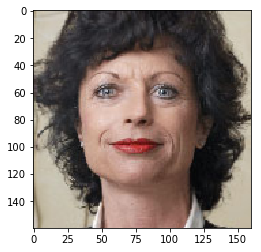

In [4]:
# 답 코드

from scipy.interpolate import Rbf

new_landmarks = np.copy(landmarks)
new_landmarks[:, 0][27:31] += 5
# new_landmarks[:, 1][27:31] += 5

grid_y, grid_x = np.mgrid[0:159:160j, 0:159:160j]

landmarks_with_zero_displacement = np.append(landmarks, [[0,0], [0, 80], [0, 159], [80, 0], [159,0], [159, 80], [159, 159], [80, 159]], axis=0)
new_landmarks_with_zero_displacement = np.append(new_landmarks, [[0,0], [0, 80], [0, 159], [80, 0], [159,0], [159, 80], [159, 159], [80, 159]], axis=0)

rbf_x = Rbf(new_landmarks_with_zero_displacement[:, 0], new_landmarks_with_zero_displacement[:, 1], landmarks_with_zero_displacement[:,0], epsilon=2, function='linear', smooth=1)
ZI_x = rbf_x(grid_x, grid_y)

rbf_y = Rbf(new_landmarks_with_zero_displacement[:, 0], new_landmarks_with_zero_displacement[:, 1], landmarks_with_zero_displacement[:,1], epsilon=2, function='linear', smooth=1)
ZI_y = rbf_y(grid_x, grid_y)

map_x = np.append([], [ar for ar in ZI_x]).reshape(160, 160).astype('float32')
map_y = np.append([], [ar for ar in ZI_y]).reshape(160, 160).astype('float32')
warped = cv2.remap(image, map_x, map_y, cv2.INTER_LINEAR)
plt.imshow(warped)

# plt.scatter(new_landmarks[:, 0][27:31], new_landmarks[:, 1][27:31], s=10, marker='.', c='b')
# plt.pause(0.001)

In [5]:
batch_size = 1
landmarks_num = len(landmarks_with_zero_displacement)
grid_shape = grid_x.shape
tf_xa = np.asarray([a.flatten() for a in [grid_x, grid_y]], dtype=np.float_) # (2, 25600)
tf_xa = np.asarray([tf_xa for _ in range(0, batch_size)], dtype=np.float_) # (batch_size, 2, 25600)

In [6]:
def rbf_tf(pred_x, pred_y, correct_points, grids, batch_size):
    def _euclidean_norm_tf(x1, x2):    
        return tf.reduce_sum(tf.sqrt(((x1 - x2)**2)), 1) 

    def _h_linear_tf(r):
        return r

    def _call_norm_tf(x1, x2):
        x1 = tf.expand_dims(x1, 3) 
        x2 = tf.expand_dims(x2, 2) 
        return norm(x1, x2)    

    # set parameters
    norm = _euclidean_norm_tf
    basis_function = _h_linear_tf
    epsilon = tf.constant(2.)
    smooth = tf.constant(1.)

    xi = tf.concat([tf.reshape(pred_x, (-1, 1, landmarks_num)), tf.reshape(pred_y, (-1, 1, landmarks_num))], 1) # (Node, 2, 76)
    N = xi.shape[-1].value # same as landmarks_num => 76
    di = tf.expand_dims(correct_points, 2) # (?, 76, 1)
        
    r = _call_norm_tf(xi, xi) # (None, 76, 76)
    A = tf.subtract(basis_function(r), tf.multiply(smooth, tf.eye(N, batch_shape= [batch_size])))

    nodes = tf.matrix_solve (A, di)

    r2 = _call_norm_tf(grids, xi)
    return tf.reshape(tf.matmul(r2, nodes), [-1, grid_shape[0], grid_shape[1]])

In [7]:
correct_x_p = landmarks_with_zero_displacement[:, 0] 
correct_y_p = landmarks_with_zero_displacement[:, 1] 
pred_x_p = new_landmarks_with_zero_displacement[:, 0] 
pred_y_p = new_landmarks_with_zero_displacement[:, 1]

In [8]:
image_height = image.shape[0]
image_width = image.shape[1]
data_channels = 3

In [9]:
with tf.Graph().as_default():
    correct_x = tf.placeholder(tf.float32, (None, landmarks_num), name= 'correct_x')
    correct_y = tf.placeholder(tf.float32, (None, landmarks_num), name= 'correct_y')
    pred_x = tf.placeholder(tf.float32, (None, landmarks_num), name= 'pred_x')
    pred_y = tf.placeholder(tf.float32, (None, landmarks_num), name= 'pred_y')
    
    grids = tf.constant(tf_xa, dtype=tf.float32, name= 'grids')
    
    rbf_x = rbf_tf(pred_x, pred_y, correct_x, grids, batch_size)
    rbf_y = rbf_tf(pred_x, pred_y, correct_y, grids, batch_size)
    
    #warped = cv2.remap(image, map_x, map_y, cv2.INTER_LINEAR)
    with tf.Session() as sess :
        sess.run(tf.global_variables_initializer())
        
        feed_dict = {
            correct_x : correct_x_p.reshape(-1, landmarks_num),
            correct_y : correct_y_p.reshape(-1, landmarks_num),
            pred_x : pred_x_p.reshape(-1, landmarks_num),
            pred_y : pred_y_p.reshape(-1, landmarks_num)
        }
        
        ZI_x_tf, ZI_y_tf = sess.run([rbf_x, rbf_y], feed_dict= feed_dict)
        ZI_x_tf, ZI_y_tf = tf.expand_dims(ZI_x_tf, 3), tf.expand_dims(ZI_y_tf, 3)
        warp = tf.concat([ZI_x_tf, ZI_y_tf], axis=3)
        
        image_ph = array_ops.placeholder(tf.float32, shape=(None,) + (image_height, image_width, data_channels), name= 'image_ph')
        warp_ph = array_ops.placeholder(tf.float32, shape=(None,) + (image_height, image_height, 2), name='warp_ph') # (None, 4, 4, 2)
        outputs = tf.cast(resampler.resampler(data=image_ph, warp=warp_ph), tf.uint8)
        out = sess.run(outputs, feed_dict={image_ph: image[np.newaxis, :], warp_ph: warp.eval()})

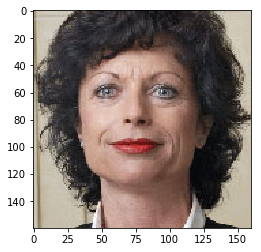

In [36]:
plt.imshow(image)

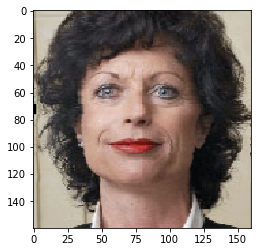

In [10]:
plt.imshow(np.squeeze(out, axis=0))

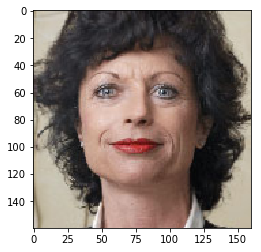

In [48]:
plt.imshow(warped)